# MESCAL 103: Scenario Attributes


In [1]:
# Setting up Notebook environment (set working directory, add path, ensure submodule inclusion)
# No need to read ;)

def setup_notebook_env():
    """Locate repository root, set working directory, and include submodules."""
    import os
    import sys
    from pathlib import Path

    def find_repo_root():
        current = Path(os.getcwd()).absolute()
        while current != current.parent:
            if (current / '.git').exists() or (current / 'submodules').exists():
                return current
            current = current.parent
        raise FileNotFoundError(f"Could not find repository root starting from {os.getcwd()}.")

    repo_root = find_repo_root()
    os.chdir(repo_root) # Change working directory

    # Add to path
    if str(repo_root) not in sys.path:
        sys.path.insert(0, str(repo_root))
        
    # Ensure all submodules are included in the path
    from vanilla.notebook_config import add_submodules_to_path    
    add_submodules_to_path()
    
    
setup_notebook_env()

In [2]:
import os
from IPython.display import Image
import plotly.express as px
import pypsa

from mescal import StudyManager
from mescal.utils.pandas_utils import flatten_df, prepend_model_prop_levels, filter_by_model_query
from mescal.utils.plotly_utils.plotly_theme import PlotlyTheme
from mescal_pypsa import PyPSADataset
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook

configure_clean_output_for_jupyter_notebook()
PlotlyTheme().apply()

In [3]:
# Register study-specific interpreters (details on this will be covered in a later notebook)
from studies.study_01_intro_to_mescal.src.study_specific_model_interpreters import ControlAreaModelInterpreter, ScigridDEBusModelInterpreter

PyPSADataset.register_interpreter(ControlAreaModelInterpreter)
PyPSADataset.register_interpreter(ScigridDEBusModelInterpreter)

# setup up study same as in previous notebooks, but this time also set attributes
study_folder = 'studies/study_01_intro_to_mescal'
networks_folder = os.path.join(study_folder, 'data/networks_scigrid_de')

n_base = pypsa.Network(os.path.join(networks_folder, 'base.nc'))
n_solar_150 = pypsa.Network(os.path.join(networks_folder, 'solar_150.nc'))
n_solar_200 = pypsa.Network(os.path.join(networks_folder, 'solar_200.nc'))
n_wind_150 = pypsa.Network(os.path.join(networks_folder, 'wind_150.nc'))
n_wind_200 = pypsa.Network(os.path.join(networks_folder, 'wind_200.nc'))

study = StudyManager.factory_from_scenarios(
    scenarios=[
        PyPSADataset(n_base,        name='base'),
        PyPSADataset(n_solar_150,   name='solar_150', attributes=dict(res_tech='solar', scaling_factor=150)),
        PyPSADataset(n_solar_200,   name='solar_200', attributes=dict(res_tech='solar', scaling_factor=200)),
        PyPSADataset(n_wind_150,    name='wind_150', attributes=dict(res_tech='wind', scaling_factor=150)),
        PyPSADataset(n_wind_200,    name='wind_200', attributes=dict(res_tech='wind', scaling_factor=200)),
    ],
    comparisons=[('solar_150', 'base'), ('solar_200', 'base'), ('wind_150', 'base'), ('wind_200', 'base')],
    export_folder=os.path.join(study_folder, 'non_versioned/output'),
)

In [4]:
scen_attributes_df = study.scen.get_attributes_concat_df()
print(scen_attributes_df)

attribute res_tech scaling_factor
dataset                          
base           NaN            NaN
solar_150    solar            150
solar_200    solar            200
wind_150      wind            150
wind_200      wind            200


Of course, the same method can be called for the collection of comparisons and returns a similar df. 

In [5]:
comp_attributes_df = study.comp.get_attributes_concat_df()
print(comp_attributes_df)

attribute         res_tech scaling_factor variation_dataset reference_dataset
dataset                                                                      
solar_150 vs base    solar            150         solar_150              base
solar_200 vs base    solar            200         solar_200              base
wind_150 vs base      wind            150          wind_150              base
wind_200 vs base      wind            200          wind_200              base


As you can see, for DatasetComparisons, the method automatically uses the attributes of the variation dataset while also including the names to variation as well as reference dataset. You could, of course, also set attributes explicitly for every comparison dataset individually.

From the previous notebooks, you might also remember that there is even a combined dataset for all scenarios + comparisons. The method even works for this one, as you can see below.

In [6]:
print(study.scen_comp.get_attributes_concat_df())

attribute                    res_tech scaling_factor variation_dataset reference_dataset
type       dataset                                                                      
scenario   base                   NaN            NaN               NaN               NaN
           solar_150            solar            150               NaN               NaN
           solar_200            solar            200               NaN               NaN
           wind_150              wind            150               NaN               NaN
           wind_200              wind            200               NaN               NaN
comparison solar_150 vs base    solar            150         solar_150              base
           solar_200 vs base    solar            200         solar_200              base
           wind_150 vs base      wind            150          wind_150              base
           wind_200 vs base      wind            200          wind_200              base


You might be wondering, when would we need these attributes? Making use of Dataset attributes is entirely optional, but is extremely useful, for example when you want to categorize or group your assessment by different attributes.

In the example below, we want to show the average price change per control area and categorize the scenarios by res_tech and scaling_factor, here we go:

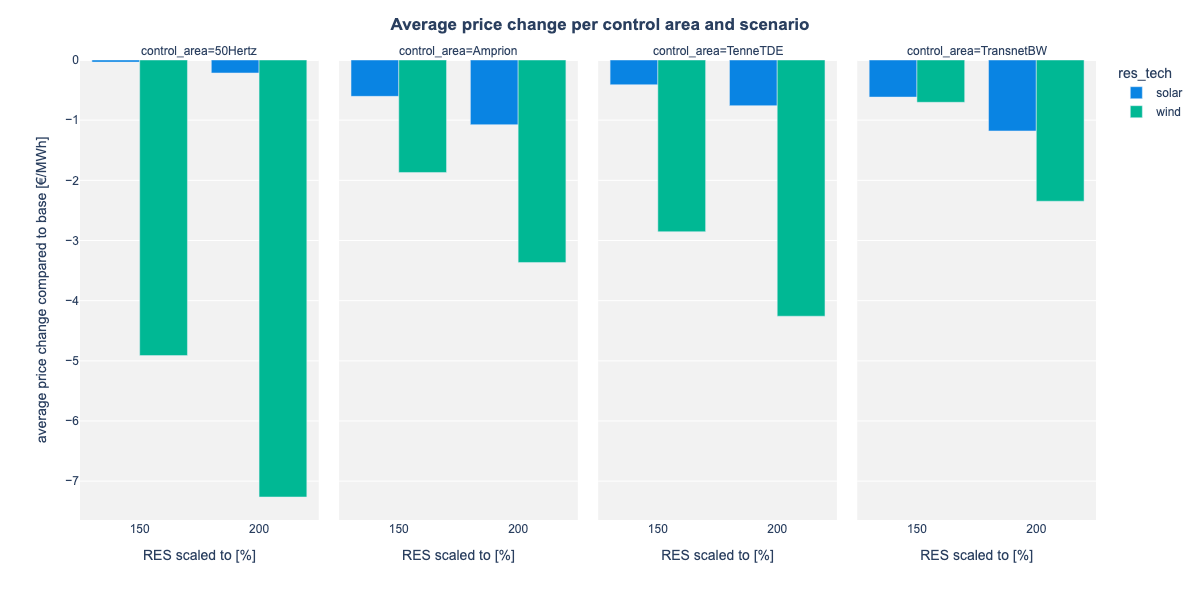

In [7]:
comp_attributes_df = study.comp.get_attributes_concat_df()
buses_model_df = study.scen.get_dataset('base').fetch('buses')
data = study.comp.fetch('buses_t.marginal_price')
data = prepend_model_prop_levels(data, buses_model_df, 'control_area')
data = data.T.groupby(level=['dataset', 'control_area']).mean().T
data = data.mean().to_frame('value')
data = prepend_model_prop_levels(data, comp_attributes_df, 'res_tech', 'scaling_factor')
data = data.reset_index()
fig = px.bar(
    data_frame=data,
    x='scaling_factor',
    y='value',
    color='res_tech',
    facet_col='control_area',
    labels={'scaling_factor': 'RES scaled to [%]', 'value': 'average price change compared to base [€/MWh]'},
    barmode='group',
)
fig.update_layout(title='<b>Average price change per control area and scenario</b>', width=1200)

# Save and display the image (using this only so that the picture is shown on GitHub)
image_path = study.export_path('mean_price_change_scenarios.png')
fig.update_layout(height=600, width=1200)
fig.write_image(image_path)
Image(image_path)

# fig.show()  # Use this instead when you are running locally and want to have full interactivity in the plot

You might have spottet that the prepend_model_prop_levels method is applied in combination with the comp_attributes_df. In this application, the attributes_df basically just functions as a model_df (mapping from object names to properties/memberships/attributes) for the index level with dataset names.

In many cases, dataset attributes are actually retrievable from the raw-data folder / file and can be interpreted based on a rule. This is especially useful if you are managing more than just a hand full of scenarios with potentially many attribute dimensions.

The used method in the example below utilizes the rule based attribute setting and sets up the study manager instance by a method call. Visit the source code if you want to see the implementation for yourself. 

In [8]:
from studies.study_01_intro_to_mescal.scripts.setup_study_manager import get_scigrid_de_study_manager

study = get_scigrid_de_study_manager()  # same study setup as from above, using rule based attribute attribution and a re-usable script.

## Key Takeaways

- **Dataset Attribute Feature**: Describe scenarios and scenario comparisons with attributes and have the information at hand during your assessment.
- **Modularity of descriptive `model_df` framework**: Treat the attributes_df as if it was a `model_df` for the dataset names and make use of tools like `filter_by_model_query` and `prepend_model_prop_levels` in combination with multi-scenario (multi-scenario-comparison) dataframes.